In [1]:
import tensorflow as tf
import numpy as np
import h5py
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import keras

In [3]:
from sklearn.metrics import confusion_matrix, precision_score
from sklearn.model_selection import train_test_split
from keras.layers import Dense,Dropout
from keras.models import Sequential
from keras.regularizers import l2
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pandas as pd

In [4]:
import numpy
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, Bidirectional , GRU , RepeatVector
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
import pandas
from keras.models import load_model
from os.path import isfile
import os
from keras.optimizers import Adam
import pickle

In [5]:
def createComparableDataset(_df):
    _df.date = pd.to_datetime(_df.date)
    _df = _df[_df['date'] >= pd.to_datetime('2015/05/04')]
    _df = _df[_df['date'] <= pd.to_datetime('2019/03/28')]
    return _df
	
def createTrainingAndTestingSet(_df):
    train = _df[_df['date'] < pd.to_datetime('2019/01/01')]
    test = _df[_df['date'] >= pd.to_datetime('2019/01/01')]
    return train ,test
	
def getFeaturesAndTargetRemoveDate(_df):
    try:
        train_y = _df['target']
        train = _df.drop(['date','target'],axis =1)
    except:
        train_y = _df['Target']
        train = _df.drop(['date','Target'],axis =1)        
    return train, train_y

In [6]:
def getStartEndDateShape(dfz):
    startDate = str(min(dfz['date']))
    endDate = str(max(dfz['date']))
    print('startDate', startDate)
    print('endDate', endDate)
    print('shape', dfz.shape)
    print('---------------------------')

# Building Model Templates

In [7]:
trainingData = pd.read_csv('train_bert_tnfi.csv')
testingData =  pd.read_csv('test_bert_tnfi.csv')

In [8]:
getStartEndDateShape(trainingData)
getStartEndDateShape(testingData)

startDate 2015-05-04
endDate 2018-12-31
shape (1336, 1615)
---------------------------
startDate 2019-01-01
endDate 2019-03-28
shape (87, 1615)
---------------------------


In [9]:
train, train_y = getFeaturesAndTargetRemoveDate(trainingData)
test, test_y = getFeaturesAndTargetRemoveDate(testingData)

In [10]:
print('train',train.shape,'test',test.shape,'len(train_y)',len(train_y),'len(test_y)',len(test_y))

train (1336, 1613) test (87, 1613) len(train_y) 1336 len(test_y) 87


In [11]:
# Naive Bayes for Baseline
from sklearn.naive_bayes import GaussianNB
def NaiveBayes(train_features , train_labels, test_features,test_labels):
    gnb = GaussianNB()
    y_pred = gnb.fit(train_features, train_labels).predict(test_features)
    print('accuracy_score',accuracy_score(y_pred, test_labels))
    print('classification_score\n',classification_report(y_pred, test_labels))
    

In [12]:
def DenseNetwork(featureLength):
    #defifne a sequentail Model
    model = Sequential()

    #Hidden Layer-1
    model.add(Dense(100,activation='relu',input_dim=featureLength,kernel_regularizer=l2(0.01)))
    model.add(Dropout(0.3, noise_shape=None, seed=None))

    #Hidden Layer-2
    model.add(Dense(100,activation = 'relu',kernel_regularizer=l2(0.01)))
    model.add(Dropout(0.3, noise_shape=None, seed=None))

    #Output layer
    model.add(Dense(1,activation='sigmoid'))
    model.summary()
    return model

In [13]:
n_epoch=125

In [14]:
def CNN_LSTMNetwork(inpuFeatures):
    #defifne a sequentail Model
    model = Sequential()

    #Hidden Layer-1
    model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu',input_shape=(inpuFeatures, 1)))
    #Hidden Layer-2
    model.add(MaxPooling1D(pool_size=2))
    #Hidden Layer-3+
    
    model.add(LSTM(100))

    #Output layer
    model.add(Dense(1,activation='sigmoid'))
    model.summary()
    return model

In [15]:
def CNN_RNNNetwork(inpuFeatures):
    #defifne a sequentail Model
    model = Sequential()

    #Hidden Layer-1
    model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu',input_shape=(inpuFeatures, 1)))
    #Hidden Layer-2
    model.add(MaxPooling1D(pool_size=2))
    #Hidden Layer-3
    model.add(keras.layers.SimpleRNN(100, activation='tanh', use_bias=True, kernel_initializer='glorot_uniform', recurrent_initializer='orthogonal', bias_initializer='zeros', kernel_regularizer=None, recurrent_regularizer=None, bias_regularizer=None, activity_regularizer=None, kernel_constraint=None, recurrent_constraint=None, bias_constraint=None, dropout=0.0, recurrent_dropout=0.0, return_sequences=False, return_state=False, go_backwards=False, stateful=False, unroll=False))

    #Output layer
    model.add(Dense(1,activation='sigmoid'))
    model.summary()
    return model

In [16]:
def CNN_GRUNetwork(inpuFeatures):
    #defifne a sequentail Model
    model = Sequential()

    #Hidden Layer-1
    model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu',input_shape=(inpuFeatures, 1)))
    #Hidden Layer-2
    model.add(MaxPooling1D(pool_size=2))
    #Hidden Layer-3
    model.add(GRU(100))

    #Output layer
    model.add(Dense(1,activation='sigmoid'))
    model.summary()
    return model

In [17]:
def CNN_BideirectionalLSTMNetwork(inpuFeatures):
    #defifne a sequentail Model
    model = Sequential()

    #Hidden Layer-1
    model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu',input_shape=(inpuFeatures, 1)))
    #Hidden Layer-2
    model.add(MaxPooling1D(pool_size=2))
    #Hidden Layer-3
    model.add(Bidirectional(LSTM(100)))

    #Output layer
    model.add(Dense(1,activation='sigmoid'))
    model.summary()
    return model

In [18]:
def evaluateModelAndTestAccuracy(model,trainX, trainY, testX, testY,n_epoch):
    
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    history = model.fit(trainX, trainY, epochs=n_epoch, validation_split=0.1,batch_size=256, verbose=1,)
    
    results = model.evaluate(testX, testY)
    
    y_pred = model.predict_classes(testX)
    print("Evaluation on test data: Loss - {0},  Acurracy - {1}".format(results[0],str(results[1]*100)))
    print('classification_score\n',classification_report(y_pred, testY))
    return history

In [19]:
def vizModelMetric(history,n_epoch):
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(np.arange(0, n_epoch), history.history["loss"], label="train_loss")
    plt.plot(np.arange(0, n_epoch), history.history["val_loss"], label="val_loss")
    plt.plot(np.arange(0, n_epoch), history.history["acc"], label="train_acc")
    plt.plot(np.arange(0, n_epoch), history.history["val_acc"], label="val_acc")
    plt.title("Training Loss and Accuracy")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend()

In [20]:
def NaivePredition(y_test):
    
    y_testCheck = y_test.copy()
    y_pred = list()
    
    for counter in range(len(y_testCheck)-1):
        y_pred.append(y_testCheck[counter])
    
    y_testCheck = y_testCheck[1:]
    print ('Model accuracy = %.3f' % accuracy_score(y_pred,y_testCheck))

    print('classification_score\n',classification_report(y_pred, y_testCheck))

# BERT- ALL SCALED

In [21]:
NaivePredition(list(test_y))

Model accuracy = 0.756
classification_score
               precision    recall  f1-score   support

         0.0       0.71      0.69      0.70        36
         1.0       0.78      0.80      0.79        50

   micro avg       0.76      0.76      0.76        86
   macro avg       0.75      0.75      0.75        86
weighted avg       0.75      0.76      0.76        86



In [22]:
NaiveBayes(train,train_y,test,test_y)

accuracy_score 0.367816091954023
classification_score
               precision    recall  f1-score   support

         0.0       0.81      0.38      0.51        77
         1.0       0.06      0.30      0.10        10

   micro avg       0.37      0.37      0.37        87
   macro avg       0.43      0.34      0.31        87
weighted avg       0.72      0.37      0.47        87



Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               161400    
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 101       
Total params: 171,601
Trainable params: 171,601
Non-trainable params: 0
_______________

Epoch 106/125
1202/1202 [==============================] - 0s 63us/step - loss: 0.1468 - acc: 0.9950 - val_loss: 1.1619 - val_acc: 0.6418
Epoch 107/125
1202/1202 [==============================] - 0s 51us/step - loss: 0.1417 - acc: 0.9967 - val_loss: 1.1807 - val_acc: 0.6269
Epoch 108/125
1202/1202 [==============================] - 0s 46us/step - loss: 0.1431 - acc: 0.9942 - val_loss: 1.3709 - val_acc: 0.6642
Epoch 109/125
1202/1202 [==============================] - 0s 45us/step - loss: 0.1458 - acc: 0.9917 - val_loss: 1.2727 - val_acc: 0.6791
Epoch 110/125
1202/1202 [==============================] - 0s 49us/step - loss: 0.1575 - acc: 0.9917 - val_loss: 1.1882 - val_acc: 0.6567
Epoch 111/125
1202/1202 [==============================] - 0s 47us/step - loss: 0.1526 - acc: 0.9917 - val_loss: 1.3198 - val_acc: 0.5970
Epoch 112/125
1202/1202 [==============================] - 0s 53us/step - loss: 0.1630 - acc: 0.9867 - val_loss: 1.4566 - val_acc: 0.5970
Epoch 113/125
1202/1202 [=========

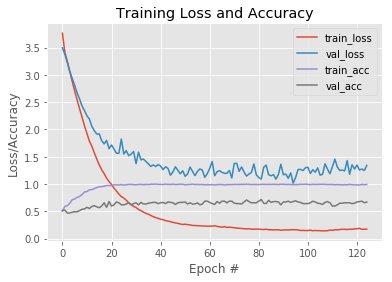

In [23]:
featureLength = train.shape[1]
vizModelMetric(evaluateModelAndTestAccuracy(DenseNetwork(featureLength),train, train_y, test, test_y ,n_epoch),n_epoch)

In [24]:
# Research paper and models -> https://github.com/EmielStoelinga/CCMLWI

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 1613, 32)          128       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 806, 32)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 101       
Total params: 53,429
Trainable params: 53,429
Non-trainable params: 0
_________________________________________________________________
Train on 1202 samples, validate on 134 samples
Epoch 1/125
1202/1202 [==============================] - 9s 8ms/step - loss: 0.6973 - acc: 0.5100 - val_loss: 0.7238 - val_acc: 0.4925
Epoch 2/125
1202/1202 [==============================] - 7s 6ms/step - loss: 0.6902 - ac

1202/1202 [==============================] - 9s 8ms/step - loss: 0.2622 - acc: 0.9027 - val_loss: 1.3553 - val_acc: 0.4627
Epoch 115/125
1202/1202 [==============================] - 7s 6ms/step - loss: 0.2660 - acc: 0.8968 - val_loss: 1.4471 - val_acc: 0.4478
Epoch 116/125
1202/1202 [==============================] - 7s 6ms/step - loss: 0.2499 - acc: 0.9010 - val_loss: 1.4234 - val_acc: 0.4701
Epoch 117/125
1202/1202 [==============================] - 7s 6ms/step - loss: 0.2329 - acc: 0.9160 - val_loss: 1.4119 - val_acc: 0.4627
Epoch 118/125
1202/1202 [==============================] - 7s 6ms/step - loss: 0.2743 - acc: 0.8860 - val_loss: 1.3780 - val_acc: 0.5000
Epoch 119/125
1202/1202 [==============================] - 7s 6ms/step - loss: 0.2708 - acc: 0.8794 - val_loss: 1.3802 - val_acc: 0.4627
Epoch 120/125
1202/1202 [==============================] - 7s 6ms/step - loss: 0.2394 - acc: 0.9018 - val_loss: 1.4352 - val_acc: 0.4403
Epoch 121/125
1202/1202 [==============================

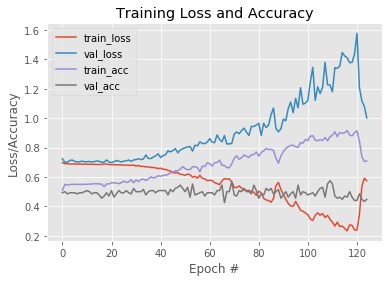

In [25]:
inputFeatures = train.shape[1]
vizModelMetric(evaluateModelAndTestAccuracy(CNN_LSTMNetwork(inputFeatures),np.expand_dims(train, axis=2), train_y, np.expand_dims(test, axis=2) , test_y ,n_epoch),n_epoch)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_2 (Conv1D)            (None, 1613, 32)          128       
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 806, 32)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 200)               106400    
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 201       
Total params: 106,729
Trainable params: 106,729
Non-trainable params: 0
_________________________________________________________________
Train on 1202 samples, validate on 134 samples
Epoch 1/125
1202/1202 [==============================] - 12s 10ms/step - loss: 0.6899 - acc: 0.5408 - val_loss: 0.7215 - val_acc: 0.4925
Epoch 2/125
1202/1202 [==============================] - 11s 9ms/step - loss: 0.6808

Epoch 114/125
1202/1202 [==============================] - 11s 9ms/step - loss: 0.3070 - acc: 0.8669 - val_loss: 1.2657 - val_acc: 0.6940
Epoch 115/125
1202/1202 [==============================] - 11s 9ms/step - loss: 0.3382 - acc: 0.8461 - val_loss: 1.4027 - val_acc: 0.6791
Epoch 116/125
1202/1202 [==============================] - 11s 9ms/step - loss: 0.3535 - acc: 0.8419 - val_loss: 1.4596 - val_acc: 0.6567
Epoch 117/125
1202/1202 [==============================] - 11s 9ms/step - loss: 0.3679 - acc: 0.8303 - val_loss: 1.2285 - val_acc: 0.7015
Epoch 118/125
1202/1202 [==============================] - 11s 9ms/step - loss: 0.3453 - acc: 0.8369 - val_loss: 1.1404 - val_acc: 0.6716
Epoch 119/125
1202/1202 [==============================] - 11s 9ms/step - loss: 0.3570 - acc: 0.8419 - val_loss: 1.2661 - val_acc: 0.6716
Epoch 120/125
1202/1202 [==============================] - 11s 9ms/step - loss: 0.4082 - acc: 0.8211 - val_loss: 1.1706 - val_acc: 0.6866
Epoch 121/125
1202/1202 [=========

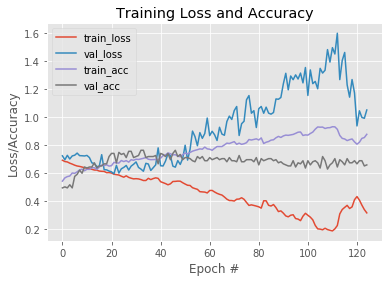

In [26]:
inputFeatures = train.shape[1]
vizModelMetric(evaluateModelAndTestAccuracy(CNN_BideirectionalLSTMNetwork(inputFeatures),np.expand_dims(train, axis=2), train_y, np.expand_dims(test, axis=2) , test_y ,n_epoch),n_epoch)

In [27]:
# inputFeatures = train.shape[1]
# n_epoch=45
# vizModelMetric(evaluateModelAndTestAccuracy(CNN_BideirectionalLSTMNetwork(inputFeatures),np.expand_dims(train, axis=2), train_y, np.expand_dims(test, axis=2) , test_y ,n_epoch),n_epoch)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_3 (Conv1D)            (None, 1613, 32)          128       
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 806, 32)           0         
_________________________________________________________________
gru_1 (GRU)                  (None, 100)               39900     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 101       
Total params: 40,129
Trainable params: 40,129
Non-trainable params: 0
_________________________________________________________________
Train on 1202 samples, validate on 134 samples
Epoch 1/125
1202/1202 [==============================] - 7s 6ms/step - loss: 0.6916 - acc: 0.5449 - val_loss: 0.7108 - val_acc: 0.4925
Epoch 2/125
1202/1202 [==============================] - 6s 5ms/step - loss: 0.6894 - ac

1202/1202 [==============================] - 6s 5ms/step - loss: 0.3062 - acc: 0.8669 - val_loss: 1.4243 - val_acc: 0.5224
Epoch 115/125
1202/1202 [==============================] - 6s 5ms/step - loss: 0.3067 - acc: 0.8686 - val_loss: 1.4135 - val_acc: 0.5299
Epoch 116/125
1202/1202 [==============================] - 6s 5ms/step - loss: 0.2872 - acc: 0.8752 - val_loss: 1.5789 - val_acc: 0.5075
Epoch 117/125
1202/1202 [==============================] - 6s 5ms/step - loss: 0.3303 - acc: 0.8552 - val_loss: 1.4992 - val_acc: 0.4701
Epoch 118/125
1202/1202 [==============================] - 6s 5ms/step - loss: 0.3580 - acc: 0.8344 - val_loss: 1.4857 - val_acc: 0.4851
Epoch 119/125
1202/1202 [==============================] - 6s 5ms/step - loss: 0.3279 - acc: 0.8511 - val_loss: 1.5676 - val_acc: 0.5299
Epoch 120/125
1202/1202 [==============================] - 6s 5ms/step - loss: 0.3158 - acc: 0.8536 - val_loss: 1.4687 - val_acc: 0.4851
Epoch 121/125
1202/1202 [==============================

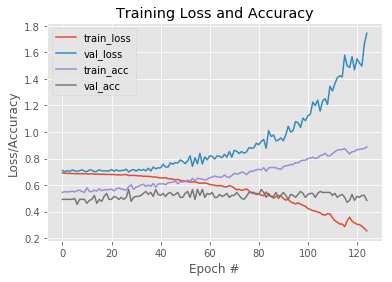

In [28]:
inputFeatures = train.shape[1]
vizModelMetric(evaluateModelAndTestAccuracy(CNN_GRUNetwork(inputFeatures),np.expand_dims(train, axis=2), train_y, np.expand_dims(test, axis=2) , test_y ,n_epoch),n_epoch)

In [29]:
# inputFeatures = train.shape[1]
# n_epoch=24
# vizModelMetric(evaluateModelAndTestAccuracy(CNN_GRUNetwork(inputFeatures),np.expand_dims(train, axis=2), train_y, np.expand_dims(test, axis=2) , test_y ,n_epoch),n_epoch)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_4 (Conv1D)            (None, 1613, 32)          128       
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 806, 32)           0         
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 100)               13300     
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 101       
Total params: 13,529
Trainable params: 13,529
Non-trainable params: 0
_________________________________________________________________
Train on 1202 samples, validate on 134 samples
Epoch 1/125
1202/1202 [==============================] - 4s 3ms/step - loss: 0.7013 - acc: 0.5067 - val_loss: 0.7030 - val_acc: 0.5075
Epoch 2/125
1202/1202 [==============================] - 3s 2ms/step - loss: 0.6892 - ac

1202/1202 [==============================] - 3s 2ms/step - loss: 0.6897 - acc: 0.5541 - val_loss: 0.7203 - val_acc: 0.5149
Epoch 115/125
1202/1202 [==============================] - 3s 2ms/step - loss: 0.6940 - acc: 0.5324 - val_loss: 0.7045 - val_acc: 0.5448
Epoch 116/125
1202/1202 [==============================] - 3s 2ms/step - loss: 0.6869 - acc: 0.5666 - val_loss: 0.7133 - val_acc: 0.5373
Epoch 117/125
1202/1202 [==============================] - 3s 2ms/step - loss: 0.6927 - acc: 0.5532 - val_loss: 0.7251 - val_acc: 0.4851
Epoch 118/125
1202/1202 [==============================] - 3s 2ms/step - loss: 0.6921 - acc: 0.5524 - val_loss: 0.7299 - val_acc: 0.4925
Epoch 119/125
1202/1202 [==============================] - 3s 2ms/step - loss: 0.6897 - acc: 0.5557 - val_loss: 0.7300 - val_acc: 0.4925
Epoch 120/125
1202/1202 [==============================] - 3s 2ms/step - loss: 0.6872 - acc: 0.5541 - val_loss: 0.7282 - val_acc: 0.4925
Epoch 121/125
1202/1202 [==============================

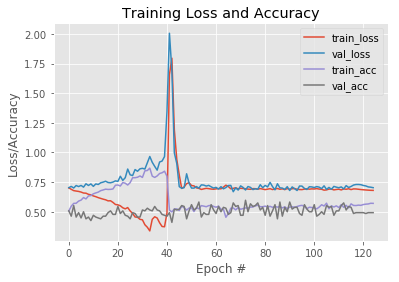

In [30]:
inputFeatures = train.shape[1]
vizModelMetric(evaluateModelAndTestAccuracy(CNN_RNNNetwork(inputFeatures),np.expand_dims(train, axis=2), train_y, np.expand_dims(test, axis=2) , test_y ,n_epoch),n_epoch)

In [31]:
# inputFeatures = train.shape[1]
# n_epoch=25
# vizModelMetric(evaluateModelAndTestAccuracy(CNN_RNNNetwork(inputFeatures),np.expand_dims(train, axis=2), train_y, np.expand_dims(test, axis=2) , test_y ,n_epoch),n_epoch)

In [32]:
# inputFeatures = train.shape[1]
# n_epoch=12
# vizModelMetric(evaluateModelAndTestAccuracy(CNN_RNNNetwork(inputFeatures),np.expand_dims(train, axis=2), train_y, np.expand_dims(test, axis=2) , test_y ,n_epoch),n_epoch)

# BERT- ALL NON-SCALED

In [33]:
trainingData = pd.read_csv('train_nS_bert_tnfi.csv')
testingData =  pd.read_csv('test_nS_bert_tnfi.csv')

getStartEndDateShape(trainingData)
getStartEndDateShape(testingData)

train, train_y = getFeaturesAndTargetRemoveDate(trainingData)
test, test_y = getFeaturesAndTargetRemoveDate(testingData)

print('train',train.shape,'test',test.shape,'len(train_y)',len(train_y),'len(test_y)',len(test_y))

startDate 2015-05-04
endDate 2018-12-31
shape (1336, 1615)
---------------------------
startDate 2019-01-01
endDate 2019-03-28
shape (87, 1615)
---------------------------
train (1336, 1613) test (87, 1613) len(train_y) 1336 len(test_y) 87


In [34]:
NaiveBayes(train,train_y,test,test_y)

accuracy_score 0.367816091954023
classification_score
               precision    recall  f1-score   support

         0.0       0.81      0.38      0.51        77
         1.0       0.06      0.30      0.10        10

   micro avg       0.37      0.37      0.37        87
   macro avg       0.43      0.34      0.31        87
weighted avg       0.72      0.37      0.47        87



In [35]:
NaivePredition(test_y)

Model accuracy = 0.756
classification_score
               precision    recall  f1-score   support

         0.0       0.71      0.69      0.70        36
         1.0       0.78      0.80      0.79        50

   micro avg       0.76      0.76      0.76        86
   macro avg       0.75      0.75      0.75        86
weighted avg       0.75      0.76      0.76        86



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 100)               161400    
_________________________________________________________________
dropout_3 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 100)               10100     
_________________________________________________________________
dropout_4 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 101       
Total params: 171,601
Trainable params: 171,601
Non-trainable params: 0
_________________________________________________________________
Train on 1202 samples, validate on 134 samples
Epoch 1/125
1202/1202 [==============================] - 1s 743us/step - loss: 3.5207 - a

Epoch 113/125
1202/1202 [==============================] - 0s 46us/step - loss: 0.2064 - acc: 0.9917 - val_loss: 1.0276 - val_acc: 0.7463
Epoch 114/125
1202/1202 [==============================] - 0s 48us/step - loss: 0.2000 - acc: 0.9925 - val_loss: 1.1914 - val_acc: 0.6940
Epoch 115/125
1202/1202 [==============================] - 0s 47us/step - loss: 0.2173 - acc: 0.9850 - val_loss: 1.0276 - val_acc: 0.7537
Epoch 116/125
1202/1202 [==============================] - 0s 47us/step - loss: 0.2112 - acc: 0.9917 - val_loss: 1.0717 - val_acc: 0.7463
Epoch 117/125
1202/1202 [==============================] - 0s 48us/step - loss: 0.2012 - acc: 0.9908 - val_loss: 1.0452 - val_acc: 0.7463
Epoch 118/125
1202/1202 [==============================] - 0s 49us/step - loss: 0.2025 - acc: 0.9925 - val_loss: 1.0436 - val_acc: 0.7313
Epoch 119/125
1202/1202 [==============================] - 0s 42us/step - loss: 0.1982 - acc: 0.9942 - val_loss: 1.1354 - val_acc: 0.7239
Epoch 120/125
1202/1202 [=========

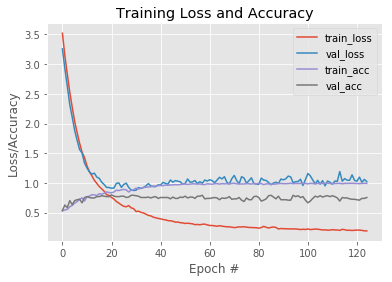

In [36]:
featureLength = train.shape[1]
vizModelMetric(evaluateModelAndTestAccuracy(DenseNetwork(featureLength),train, train_y, test, test_y ,n_epoch),n_epoch)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_5 (Conv1D)            (None, 1613, 32)          128       
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 806, 32)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 101       
Total params: 53,429
Trainable params: 53,429
Non-trainable params: 0
_________________________________________________________________
Train on 1202 samples, validate on 134 samples
Epoch 1/125
1202/1202 [==============================] - 8s 7ms/step - loss: 0.6905 - acc: 0.5300 - val_loss: 0.7005 - val_acc: 0.4925
Epoch 2/125
1202/1202 [==============================] - 7s 6ms/step - loss: 0.6895 - ac

1202/1202 [==============================] - 7s 6ms/step - loss: 0.6830 - acc: 0.5574 - val_loss: 0.6939 - val_acc: 0.5746
Epoch 115/125
1202/1202 [==============================] - 7s 6ms/step - loss: 0.6832 - acc: 0.5582 - val_loss: 0.6927 - val_acc: 0.5821
Epoch 116/125
1202/1202 [==============================] - 7s 6ms/step - loss: 0.6827 - acc: 0.5591 - val_loss: 0.6931 - val_acc: 0.5821
Epoch 117/125
1202/1202 [==============================] - 7s 6ms/step - loss: 0.6829 - acc: 0.5582 - val_loss: 0.6951 - val_acc: 0.5149
Epoch 118/125
1202/1202 [==============================] - 7s 6ms/step - loss: 0.6825 - acc: 0.5574 - val_loss: 0.6950 - val_acc: 0.5224
Epoch 119/125
1202/1202 [==============================] - 7s 6ms/step - loss: 0.6823 - acc: 0.5566 - val_loss: 0.6946 - val_acc: 0.5448
Epoch 120/125
1202/1202 [==============================] - 7s 6ms/step - loss: 0.6821 - acc: 0.5582 - val_loss: 0.6928 - val_acc: 0.5672
Epoch 121/125
1202/1202 [==============================

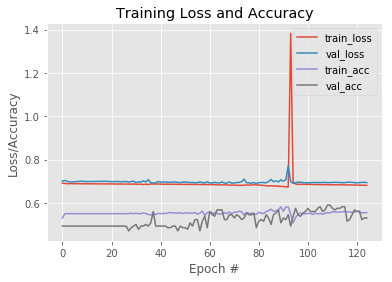

In [37]:
inputFeatures = train.shape[1]
vizModelMetric(evaluateModelAndTestAccuracy(CNN_LSTMNetwork(inputFeatures),np.expand_dims(train, axis=2), train_y, np.expand_dims(test, axis=2) , test_y ,n_epoch),n_epoch)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_6 (Conv1D)            (None, 1613, 32)          128       
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 806, 32)           0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 200)               106400    
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 201       
Total params: 106,729
Trainable params: 106,729
Non-trainable params: 0
_________________________________________________________________
Train on 1202 samples, validate on 134 samples
Epoch 1/125
1202/1202 [==============================] - 13s 10ms/step - loss: 0.6870 - acc: 0.5333 - val_loss: 0.7389 - val_acc: 0.4925
Epoch 2/125
1202/1202 [==============================] - 11s 9ms/step - loss: 0.6832

Epoch 114/125
1202/1202 [==============================] - 11s 9ms/step - loss: 0.3280 - acc: 0.8419 - val_loss: 0.9439 - val_acc: 0.6418
Epoch 115/125
1202/1202 [==============================] - 11s 9ms/step - loss: 0.3183 - acc: 0.8544 - val_loss: 0.8564 - val_acc: 0.6791
Epoch 116/125
1202/1202 [==============================] - 11s 9ms/step - loss: 0.3224 - acc: 0.8386 - val_loss: 0.8221 - val_acc: 0.7313
Epoch 117/125
1202/1202 [==============================] - 11s 9ms/step - loss: 0.3605 - acc: 0.8245 - val_loss: 0.8215 - val_acc: 0.6940
Epoch 118/125
1202/1202 [==============================] - 11s 9ms/step - loss: 0.3500 - acc: 0.8403 - val_loss: 0.8905 - val_acc: 0.6642
Epoch 119/125
1202/1202 [==============================] - 11s 9ms/step - loss: 0.3554 - acc: 0.8319 - val_loss: 0.7204 - val_acc: 0.7164
Epoch 120/125
1202/1202 [==============================] - 11s 9ms/step - loss: 0.3378 - acc: 0.8353 - val_loss: 0.7948 - val_acc: 0.6866
Epoch 121/125
1202/1202 [=========

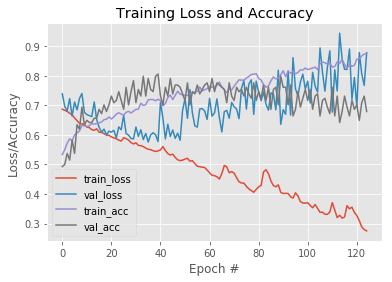

In [38]:
inputFeatures = train.shape[1]
vizModelMetric(evaluateModelAndTestAccuracy(CNN_BideirectionalLSTMNetwork(inputFeatures),np.expand_dims(train, axis=2), train_y, np.expand_dims(test, axis=2) , test_y ,n_epoch),n_epoch)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_7 (Conv1D)            (None, 1613, 32)          128       
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, 806, 32)           0         
_________________________________________________________________
gru_2 (GRU)                  (None, 100)               39900     
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 101       
Total params: 40,129
Trainable params: 40,129
Non-trainable params: 0
_________________________________________________________________
Train on 1202 samples, validate on 134 samples
Epoch 1/125
1202/1202 [==============================] - 7s 6ms/step - loss: 0.6924 - acc: 0.5042 - val_loss: 0.6991 - val_acc: 0.4925
Epoch 2/125
1202/1202 [==============================] - 6s 5ms/step - loss: 0.6886 - ac

1202/1202 [==============================] - 6s 5ms/step - loss: 0.6683 - acc: 0.5923 - val_loss: 0.7246 - val_acc: 0.5000
Epoch 115/125
1202/1202 [==============================] - 6s 5ms/step - loss: 0.6703 - acc: 0.5832 - val_loss: 0.7059 - val_acc: 0.4776
Epoch 116/125
1202/1202 [==============================] - 6s 5ms/step - loss: 0.6735 - acc: 0.5998 - val_loss: 0.7073 - val_acc: 0.4701
Epoch 117/125
1202/1202 [==============================] - 6s 5ms/step - loss: 0.6718 - acc: 0.5849 - val_loss: 0.7169 - val_acc: 0.4776
Epoch 118/125
1202/1202 [==============================] - 6s 5ms/step - loss: 0.6709 - acc: 0.5832 - val_loss: 0.7194 - val_acc: 0.4627
Epoch 119/125
1202/1202 [==============================] - 6s 5ms/step - loss: 0.6671 - acc: 0.6073 - val_loss: 0.7252 - val_acc: 0.4403
Epoch 120/125
1202/1202 [==============================] - 6s 5ms/step - loss: 0.6657 - acc: 0.5899 - val_loss: 0.7426 - val_acc: 0.5000
Epoch 121/125
1202/1202 [==============================

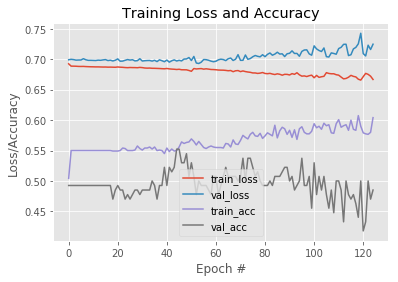

In [39]:
inputFeatures = train.shape[1]
vizModelMetric(evaluateModelAndTestAccuracy(CNN_GRUNetwork(inputFeatures),np.expand_dims(train, axis=2), train_y, np.expand_dims(test, axis=2) , test_y ,n_epoch),n_epoch)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_8 (Conv1D)            (None, 1613, 32)          128       
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, 806, 32)           0         
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 100)               13300     
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 101       
Total params: 13,529
Trainable params: 13,529
Non-trainable params: 0
_________________________________________________________________
Train on 1202 samples, validate on 134 samples
Epoch 1/125
1202/1202 [==============================] - 4s 4ms/step - loss: 0.7018 - acc: 0.5050 - val_loss: 0.7053 - val_acc: 0.5000
Epoch 2/125
1202/1202 [==============================] - 3s 2ms/step - loss: 0.6852 - ac

1202/1202 [==============================] - 3s 2ms/step - loss: 0.1191 - acc: 0.9684 - val_loss: 1.4767 - val_acc: 0.4478
Epoch 115/125
1202/1202 [==============================] - 3s 2ms/step - loss: 0.1080 - acc: 0.9667 - val_loss: 1.7378 - val_acc: 0.4925
Epoch 116/125
1202/1202 [==============================] - 3s 2ms/step - loss: 0.1117 - acc: 0.9700 - val_loss: 1.6908 - val_acc: 0.4403
Epoch 117/125
1202/1202 [==============================] - 3s 2ms/step - loss: 0.1197 - acc: 0.9617 - val_loss: 1.6441 - val_acc: 0.4925
Epoch 118/125
1202/1202 [==============================] - 3s 2ms/step - loss: 0.1305 - acc: 0.9559 - val_loss: 1.5508 - val_acc: 0.4328
Epoch 119/125
1202/1202 [==============================] - 3s 2ms/step - loss: 0.1389 - acc: 0.9576 - val_loss: 1.5612 - val_acc: 0.4701
Epoch 120/125
1202/1202 [==============================] - 3s 2ms/step - loss: 0.1258 - acc: 0.9584 - val_loss: 1.5835 - val_acc: 0.4701
Epoch 121/125
1202/1202 [==============================

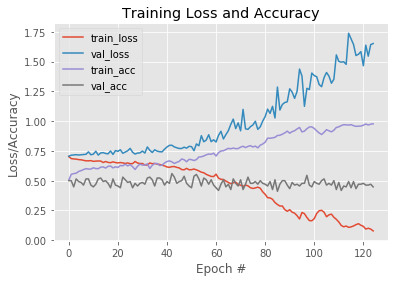

In [40]:
inputFeatures = train.shape[1]
vizModelMetric(evaluateModelAndTestAccuracy(CNN_RNNNetwork(inputFeatures),np.expand_dims(train, axis=2), train_y, np.expand_dims(test, axis=2) , test_y ,n_epoch),n_epoch)

# BERT- SCALED Engineered Feature and UNSCALED BERT dimensions

In [41]:
trainingData = pd.read_csv('train_SEFnNSB_bert_tnfi.csv')
testingData =  pd.read_csv('test_SEFnNSB_bert_tnfi.csv')

In [42]:
train, train_y = getFeaturesAndTargetRemoveDate(trainingData)
test, test_y = getFeaturesAndTargetRemoveDate(testingData)

getStartEndDateShape(trainingData)
getStartEndDateShape(testingData)

print('train',train.shape,'test',test.shape,'len(train_y)',len(train_y),'len(test_y)',len(test_y))

startDate 2015-05-04
endDate 2018-12-31
shape (1336, 1615)
---------------------------
startDate 2019-01-01
endDate 2019-03-28
shape (87, 1615)
---------------------------
train (1336, 1613) test (87, 1613) len(train_y) 1336 len(test_y) 87


In [43]:
NaiveBayes(train,train_y,test,test_y)

accuracy_score 0.367816091954023
classification_score
               precision    recall  f1-score   support

         0.0       0.81      0.38      0.51        77
         1.0       0.06      0.30      0.10        10

   micro avg       0.37      0.37      0.37        87
   macro avg       0.43      0.34      0.31        87
weighted avg       0.72      0.37      0.47        87



In [44]:
NaivePredition(list(test_y))

Model accuracy = 0.756
classification_score
               precision    recall  f1-score   support

         0.0       0.71      0.69      0.70        36
         1.0       0.78      0.80      0.79        50

   micro avg       0.76      0.76      0.76        86
   macro avg       0.75      0.75      0.75        86
weighted avg       0.75      0.76      0.76        86



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 100)               161400    
_________________________________________________________________
dropout_5 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 100)               10100     
_________________________________________________________________
dropout_6 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 101       
Total params: 171,601
Trainable params: 171,601
Non-trainable params: 0
_________________________________________________________________
Train on 1202 samples, validate on 134 samples
Epoch 1/125
1202/1202 [==============================] - 1s 1ms/step - loss: 3.4974 - acc

Epoch 113/125
1202/1202 [==============================] - 0s 46us/step - loss: 0.2353 - acc: 0.9834 - val_loss: 0.9961 - val_acc: 0.7537
Epoch 114/125
1202/1202 [==============================] - 0s 49us/step - loss: 0.2173 - acc: 0.9892 - val_loss: 1.0580 - val_acc: 0.7836
Epoch 115/125
1202/1202 [==============================] - 0s 55us/step - loss: 0.2154 - acc: 0.9875 - val_loss: 1.0814 - val_acc: 0.7687
Epoch 116/125
1202/1202 [==============================] - 0s 52us/step - loss: 0.2076 - acc: 0.9908 - val_loss: 1.0819 - val_acc: 0.7687
Epoch 117/125
1202/1202 [==============================] - 0s 45us/step - loss: 0.2039 - acc: 0.9950 - val_loss: 1.1618 - val_acc: 0.7239
Epoch 118/125
1202/1202 [==============================] - 0s 62us/step - loss: 0.2062 - acc: 0.9900 - val_loss: 1.1127 - val_acc: 0.7313
Epoch 119/125
1202/1202 [==============================] - 0s 48us/step - loss: 0.1988 - acc: 0.9933 - val_loss: 1.1474 - val_acc: 0.6940
Epoch 120/125
1202/1202 [=========

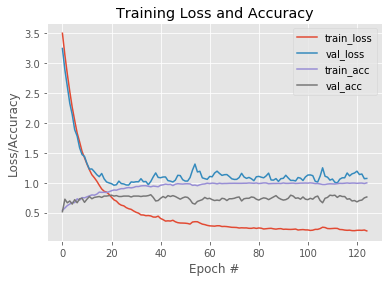

In [45]:
featureLength = train.shape[1]
vizModelMetric(evaluateModelAndTestAccuracy(DenseNetwork(featureLength),train, train_y, test, test_y ,n_epoch),n_epoch)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_9 (Conv1D)            (None, 1613, 32)          128       
_________________________________________________________________
max_pooling1d_9 (MaxPooling1 (None, 806, 32)           0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 101       
Total params: 53,429
Trainable params: 53,429
Non-trainable params: 0
_________________________________________________________________
Train on 1202 samples, validate on 134 samples
Epoch 1/125
1202/1202 [==============================] - 9s 7ms/step - loss: 0.6912 - acc: 0.5175 - val_loss: 0.6984 - val_acc: 0.4925
Epoch 2/125
1202/1202 [==============================] - 7s 6ms/step - loss: 0.6878 - ac

1202/1202 [==============================] - 7s 6ms/step - loss: 0.6722 - acc: 0.5790 - val_loss: 0.7033 - val_acc: 0.4851
Epoch 115/125
1202/1202 [==============================] - 7s 6ms/step - loss: 0.6711 - acc: 0.5824 - val_loss: 0.7085 - val_acc: 0.5000
Epoch 116/125
1202/1202 [==============================] - 7s 6ms/step - loss: 0.6711 - acc: 0.5857 - val_loss: 0.7130 - val_acc: 0.5224
Epoch 117/125
1202/1202 [==============================] - 7s 6ms/step - loss: 0.6696 - acc: 0.5715 - val_loss: 0.7043 - val_acc: 0.5448
Epoch 118/125
1202/1202 [==============================] - 7s 6ms/step - loss: 0.6724 - acc: 0.5807 - val_loss: 0.7117 - val_acc: 0.5522
Epoch 119/125
1202/1202 [==============================] - 7s 6ms/step - loss: 0.6814 - acc: 0.5757 - val_loss: 0.7058 - val_acc: 0.4925
Epoch 120/125
1202/1202 [==============================] - 7s 6ms/step - loss: 0.6682 - acc: 0.5932 - val_loss: 0.7038 - val_acc: 0.5448
Epoch 121/125
1202/1202 [==============================

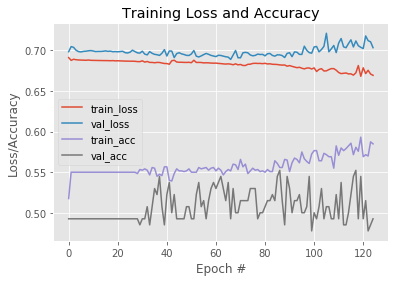

In [46]:
inputFeatures = train.shape[1]
vizModelMetric(evaluateModelAndTestAccuracy(CNN_LSTMNetwork(inputFeatures),np.expand_dims(train, axis=2), train_y, np.expand_dims(test, axis=2) , test_y ,n_epoch),n_epoch)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_10 (Conv1D)           (None, 1613, 32)          128       
_________________________________________________________________
max_pooling1d_10 (MaxPooling (None, 806, 32)           0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, 200)               106400    
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 201       
Total params: 106,729
Trainable params: 106,729
Non-trainable params: 0
_________________________________________________________________
Train on 1202 samples, validate on 134 samples
Epoch 1/125
1202/1202 [==============================] - 13s 11ms/step - loss: 0.6897 - acc: 0.5183 - val_loss: 0.7242 - val_acc: 0.4925
Epoch 2/125
1202/1202 [==============================] - 11s 9ms/step - loss: 0.6824

Epoch 114/125
1202/1202 [==============================] - 11s 9ms/step - loss: 0.2938 - acc: 0.8661 - val_loss: 0.8868 - val_acc: 0.6642
Epoch 115/125
1202/1202 [==============================] - 11s 9ms/step - loss: 0.2767 - acc: 0.8777 - val_loss: 0.9245 - val_acc: 0.6716
Epoch 116/125
1202/1202 [==============================] - 11s 9ms/step - loss: 0.2610 - acc: 0.8910 - val_loss: 0.9223 - val_acc: 0.6716
Epoch 117/125
1202/1202 [==============================] - 11s 9ms/step - loss: 0.2552 - acc: 0.8968 - val_loss: 0.9223 - val_acc: 0.6791
Epoch 118/125
1202/1202 [==============================] - 11s 9ms/step - loss: 0.2554 - acc: 0.8902 - val_loss: 0.9049 - val_acc: 0.6866
Epoch 119/125
1202/1202 [==============================] - 11s 9ms/step - loss: 0.2458 - acc: 0.8977 - val_loss: 0.9906 - val_acc: 0.6567
Epoch 120/125
1202/1202 [==============================] - 11s 9ms/step - loss: 0.2390 - acc: 0.8960 - val_loss: 0.9812 - val_acc: 0.6642
Epoch 121/125
1202/1202 [=========

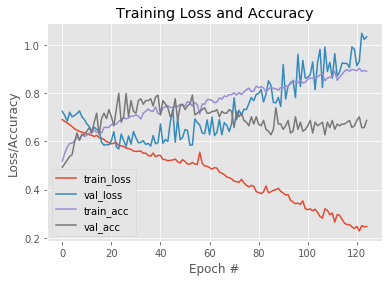

In [47]:
inputFeatures = train.shape[1]
vizModelMetric(evaluateModelAndTestAccuracy(CNN_BideirectionalLSTMNetwork(inputFeatures),np.expand_dims(train, axis=2), train_y, np.expand_dims(test, axis=2) , test_y ,n_epoch),n_epoch)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_11 (Conv1D)           (None, 1613, 32)          128       
_________________________________________________________________
max_pooling1d_11 (MaxPooling (None, 806, 32)           0         
_________________________________________________________________
gru_3 (GRU)                  (None, 100)               39900     
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 101       
Total params: 40,129
Trainable params: 40,129
Non-trainable params: 0
_________________________________________________________________
Train on 1202 samples, validate on 134 samples
Epoch 1/125
1202/1202 [==============================] - 8s 6ms/step - loss: 0.6900 - acc: 0.5383 - val_loss: 0.7003 - val_acc: 0.4925
Epoch 2/125
1202/1202 [==============================] - 6s 5ms/step - loss: 0.6886 - ac

1202/1202 [==============================] - 6s 5ms/step - loss: 0.6701 - acc: 0.5807 - val_loss: 0.7131 - val_acc: 0.5373
Epoch 115/125
1202/1202 [==============================] - 6s 5ms/step - loss: 0.6698 - acc: 0.5874 - val_loss: 0.7146 - val_acc: 0.4925
Epoch 116/125
1202/1202 [==============================] - 6s 5ms/step - loss: 0.6642 - acc: 0.6023 - val_loss: 0.7299 - val_acc: 0.5000
Epoch 117/125
1202/1202 [==============================] - 6s 5ms/step - loss: 0.6699 - acc: 0.5890 - val_loss: 0.7287 - val_acc: 0.5075
Epoch 118/125
1202/1202 [==============================] - 6s 5ms/step - loss: 0.6716 - acc: 0.5715 - val_loss: 0.7006 - val_acc: 0.5000
Epoch 119/125
1202/1202 [==============================] - 6s 5ms/step - loss: 0.6805 - acc: 0.5799 - val_loss: 0.6990 - val_acc: 0.5000
Epoch 120/125
1202/1202 [==============================] - 6s 5ms/step - loss: 0.6769 - acc: 0.5907 - val_loss: 0.7141 - val_acc: 0.4925
Epoch 121/125
1202/1202 [==============================

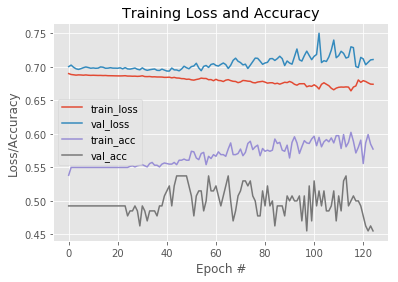

In [48]:
inputFeatures = train.shape[1]
vizModelMetric(evaluateModelAndTestAccuracy(CNN_GRUNetwork(inputFeatures),np.expand_dims(train, axis=2), train_y, np.expand_dims(test, axis=2) , test_y ,n_epoch),n_epoch)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_12 (Conv1D)           (None, 1613, 32)          128       
_________________________________________________________________
max_pooling1d_12 (MaxPooling (None, 806, 32)           0         
_________________________________________________________________
simple_rnn_3 (SimpleRNN)     (None, 100)               13300     
_________________________________________________________________
dense_21 (Dense)             (None, 1)                 101       
Total params: 13,529
Trainable params: 13,529
Non-trainable params: 0
_________________________________________________________________
Train on 1202 samples, validate on 134 samples
Epoch 1/125
1202/1202 [==============================] - 5s 4ms/step - loss: 0.6942 - acc: 0.5349 - val_loss: 0.6908 - val_acc: 0.5149
Epoch 2/125
1202/1202 [==============================] - 3s 2ms/step - loss: 0.6907 - ac

1202/1202 [==============================] - 3s 2ms/step - loss: 0.2375 - acc: 0.9077 - val_loss: 1.3841 - val_acc: 0.5299
Epoch 115/125
1202/1202 [==============================] - 3s 2ms/step - loss: 0.2142 - acc: 0.9235 - val_loss: 1.3569 - val_acc: 0.5224
Epoch 116/125
1202/1202 [==============================] - 3s 2ms/step - loss: 0.2144 - acc: 0.9168 - val_loss: 1.4572 - val_acc: 0.4851
Epoch 117/125
1202/1202 [==============================] - 3s 2ms/step - loss: 0.1936 - acc: 0.9210 - val_loss: 1.3628 - val_acc: 0.4701
Epoch 118/125
1202/1202 [==============================] - 3s 2ms/step - loss: 0.1833 - acc: 0.9359 - val_loss: 1.5613 - val_acc: 0.5224
Epoch 119/125
1202/1202 [==============================] - 3s 2ms/step - loss: 0.1989 - acc: 0.9326 - val_loss: 1.4091 - val_acc: 0.4776
Epoch 120/125
1202/1202 [==============================] - 3s 2ms/step - loss: 0.2010 - acc: 0.9285 - val_loss: 1.3744 - val_acc: 0.5224
Epoch 121/125
1202/1202 [==============================

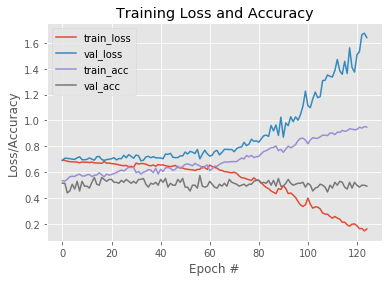

In [49]:
inputFeatures = train.shape[1]
vizModelMetric(evaluateModelAndTestAccuracy(CNN_RNNNetwork(inputFeatures),np.expand_dims(train, axis=2), train_y, np.expand_dims(test, axis=2) , test_y ,n_epoch),n_epoch)